# Trained Variable Size Flow Matching Model Demo

This notebook demonstrates loading and using the trained Variable Size Flow Matching model with interactive visualization.

In [1]:
# Import required libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import time
import os

# Add current directory to path
sys.path.append('.')

from modules import run_complete_pipeline
from hierarchical_pipeline import run_hierarchical_generation
from flow_matching_variable_size import VariableSizeFlowMatchingModel, sample_from_variable_size_flow_matching

print("Libraries imported successfully!")

Libraries imported successfully!


## Load the Trained Model

In [2]:
def load_trained_model():
    """Load the trained Variable Size Flow Matching model."""
    print("Loading trained model...")
    model = VariableSizeFlowMatchingModel(max_size=150, hidden_dims=[512, 1024, 1024, 512])
    
    # Try to load the existing model file
    model_path = 'heterogeneous_flow_matching_model.pth'
    if not os.path.exists(model_path):
        print(f"Model file {model_path} not found. Please run the training first:")
        print("python flow_matching_heterogeneous_demo.py")
        raise FileNotFoundError(f"Model file not found: {model_path}")
    
    state_dict = torch.load(model_path, map_location='cpu')
    filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith('output_projection.')}
    model.load_state_dict(filtered_state_dict, strict=False)
    model.eval()
    print("Model loaded successfully!")
    return model

# Load the model
model = load_trained_model()

Loading trained model...
Model loaded successfully!


## Generate Test Data

In [3]:
def generate_test_data():
    """Generate test data using the pipeline."""
    print("Generating test data...")
    U, V, X, masks, prob_matrix = run_complete_pipeline(
        N=15, T=20, d=5, L_X=2, L_mask=3, num_masks=3,
        latent_seed=42, data_seed=43, mask_seed=44
    )
    
    # Create hierarchical data
    J, K = 3, 4
    data_matrices_jk = np.zeros((J, K, 15, 20))
    masking_matrices_jk = np.zeros((J, K, 15, 20))
    
    for j in range(J):
        for k in range(K):
            data_matrices_jk[j, k] = X
            mask_idx = (j * K + k) % len(masks)
            masking_matrices_jk[j, k] = masks[mask_idx]
    
    # Generate big matrix
    big_data_matrix, big_mask_matrices, P_M, sampled_pairs = run_hierarchical_generation(
        data_matrices_jk, masking_matrices_jk,
        B=6, data_L=2, mask_L=2, num_big_masks=1,
        data_seed=45, mask_seed=46, pair_seed=47
    )
    
    print(f"Data matrix shape: {big_data_matrix.shape}")
    print(f"Mask matrix shape: {big_mask_matrices[0].shape}")
    return big_data_matrix, big_mask_matrices[0]

# Generate test data
data_matrix, original_mask = generate_test_data()





Generating test data...
Step 1: U shape (15, 5), V shape (20, 5)
Step 2: X shape (15, 20)
Step 3: Probability matrix shape (15, 20)
Generated 3 masking matrices, each shape: (15, 20)
Data matrix shape: (45, 80)
Mask matrix shape: (45, 80)


## Generate Mask Using the Model

In [4]:
def generate_mask_from_model(model, data_matrix):
    """Generate mask using the trained model."""
    print("Generating mask using model...")
    start_time = time.time()
    
    test_data = torch.FloatTensor(data_matrix.flatten()).unsqueeze(0)
    generated_mask = sample_from_variable_size_flow_matching(model, test_data, num_steps=100)
    generated_mask = generated_mask.squeeze(0).detach().numpy().reshape(data_matrix.shape)
    
    generation_time = time.time() - start_time
    print(f"Generation time: {generation_time:.3f}s")
    print(f"Generated mask shape: {generated_mask.shape}")
    print(f"Mask values range: [{generated_mask.min():.3f}, {generated_mask.max():.3f}]")
    
    return generated_mask

# Generate mask using the model
generated_mask = generate_mask_from_model(model, data_matrix)




Generating mask using model...
Generation time: 0.276s
Generated mask shape: (45, 80)
Mask values range: [-1.307, 1.131]


## Calculate Performance Metrics

In [5]:
def calculate_metrics(original_mask, generated_mask):
    """Calculate performance metrics."""
    orig_flat = original_mask.flatten()
    gen_flat = generated_mask.flatten()
    
    mae = np.mean(np.abs(gen_flat - orig_flat))
    mse = np.mean((gen_flat - orig_flat) ** 2)
    binary_orig = (orig_flat > 0.5).astype(float)
    binary_gen = (gen_flat > 0.5).astype(float)
    accuracy = np.mean(binary_orig == binary_gen)
    correlation = np.corrcoef(orig_flat, gen_flat)[0, 1]
    
    return {
        'mae': mae,
        'mse': mse,
        'accuracy': accuracy,
        'correlation': correlation
    }

# Calculate metrics
metrics = calculate_metrics(original_mask, generated_mask)

print("Performance Metrics:")
print(f"MAE: {metrics['mae']:.4f}")
print(f"MSE: {metrics['mse']:.4f}")
print(f"Binary Accuracy: {metrics['accuracy']:.4f}")
print(f"Correlation: {metrics['correlation']:.4f}")

Performance Metrics:
MAE: 0.4902
MSE: 0.4218
Binary Accuracy: 0.6594
Correlation: -0.0063


## Visualize Results

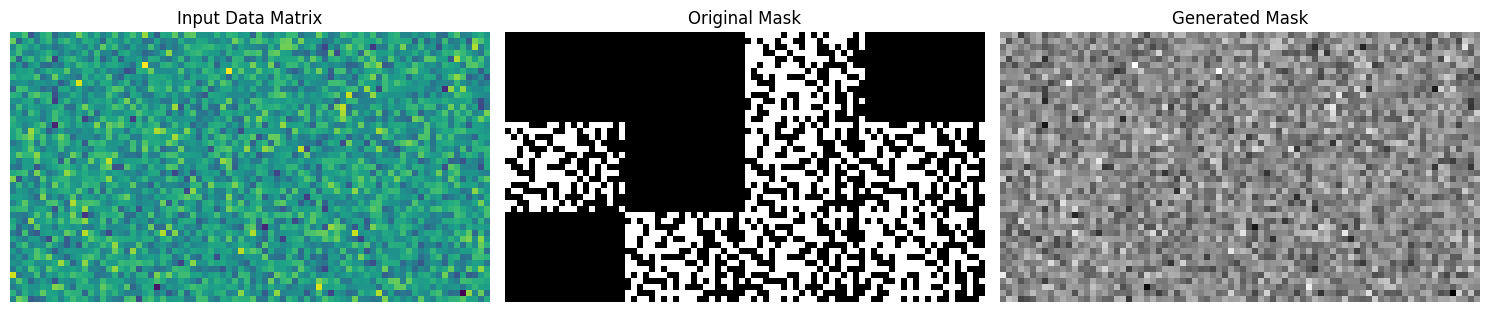


Demo completed! Results saved as 'model_demo_results.png'


In [6]:
def visualize_results(data_matrix, original_mask, generated_mask):
    """Visualize the results."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(data_matrix, cmap='viridis')
    axes[0].set_title('Input Data Matrix')
    axes[0].axis('off')
    
    axes[1].imshow(original_mask, cmap='gray')
    axes[1].set_title('Original Mask')
    axes[1].axis('off')
    
    axes[2].imshow(generated_mask, cmap='gray')
    axes[2].set_title('Generated Mask')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig('model_demo_results.png', dpi=150, bbox_inches='tight')
    plt.show()

# Visualize results
visualize_results(data_matrix, original_mask, generated_mask)

print("\nDemo completed! Results saved as 'model_demo_results.png'")

## Interactive Analysis (Optional)

You can now interactively explore the results by examining the data matrices and masks.

In [ ]:
# Interactive exploration
print("Data matrix statistics:")
print(f"Shape: {data_matrix.shape}")
print(f"Min: {data_matrix.min():.3f}")
print(f"Max: {data_matrix.max():.3f}")
print(f"Mean: {data_matrix.mean():.3f}")
print(f"Std: {data_matrix.std():.3f}")

print("\nOriginal mask statistics:")
print(f"Shape: {original_mask.shape}")
print(f"Min: {original_mask.min():.3f}")
print(f"Max: {original_mask.max():.3f}")
print(f"Mean: {original_mask.mean():.3f}")
print(f"Binary ratio: {(original_mask > 0.5).sum() / original_mask.size:.3f}")

print("\nGenerated mask statistics:")
print(f"Shape: {generated_mask.shape}")
print(f"Min: {generated_mask.min():.3f}")
print(f"Max: {generated_mask.max():.3f}")
print(f"Mean: {generated_mask.mean():.3f}")
print(f"Binary ratio: {(generated_mask > 0.5).sum() / generated_mask.size:.3f}")